# Info

This notebook performs data processing to have a dataset which is comfortable to work with


# Imports & Magics

In [1]:
%matplotlib inline
from utils.setup import *

In [2]:
X_train = pd.read_csv(TRAIN_INPUT_RAW)
y_train = pd.read_csv(TRAIN_OUTPUT_RAW)
test = pd.read_csv(TEST_INPUT_RAW)

# Merging

In [3]:
test_id = list(test['IDS'])

In [4]:
df_feat = pd.concat([X_train, test])

In [5]:
df_feat.set_index('IDS', inplace=True, drop=False)
df_feat.sort_index(inplace=True)
df_feat['Horodate'] = df_feat['Horodate'].apply(lambda x : pd.to_datetime(date_parser(x).strftime("%d/%m/%Y %H:%M")))
df_feat['Horodate'] = df_feat['Horodate'].apply(pd.to_datetime).sort_values().values
df_feat.set_index('Horodate', inplace=True)

In [6]:
X_train = df_feat[~df_feat['IDS'].isin(test_id)]
test = df_feat[df_feat['IDS'].isin(test_id)]

In [7]:
y_train.drop(['Horodate_UTC', 'Horodate', 'Mois'],inplace=True,axis=1)

In [8]:
train = X_train.reset_index().merge(y_train, how="left").set_index('Horodate')

In [9]:
train = train['2013-10-13':'2018-10-13']

# Temperature

Converting temperature from celcius to kelvin to avoid having negative values

In [10]:
# train['Température normale lissée (°Celcius)'] = train['Température normale lissée (°Celcius)'].apply(lambda x: x+273.15)
# train['Température réalisée lissée (°Celcius)'] = train['Température réalisée lissée (°Celcius)'].apply(lambda x: x+273.15)
# train = train.rename(columns={'Température normale lissée (°Celcius)': 'Température normale lissée (°K)', 'Température réalisée lissée (°Celcius)': 'Température réalisée lissée (°K)'})

In [11]:
# test['Température normale lissée (°Celcius)'] = test['Température normale lissée (°Celcius)'].apply(lambda x: x+273.15)
# test['Température réalisée lissée (°Celcius)'] = test['Température réalisée lissée (°Celcius)'].apply(lambda x: x+273.15)
# test = test.rename(columns={'Température normale lissée (°Celcius)': 'Température normale lissée (°K)', 'Température réalisée lissée (°Celcius)': 'Température réalisée lissée (°K)'})

# Horodate

In order to do Time Series, I use Horodate as my dataframe index. I will use the "dd/mm/yyyy hh:mm" date format and use the french timezone for a better understanding of the problem. I drop month and horodate_utc columns as we don't need them.

Here we have a big problem : the reindexing seems to have mix the data which were well ordered before. Enedis must have mixed the horodate, indeed we can see that the first date is indexed "915". We will have to re order the data...

According to Enedis :
- Training files include data for the period [13/10/2013 - 12/10/2018] excluding the [01/07/2017 - 30/06/2018] period.
- Regarding the 3 commercial profiles, data only start on Nov 1st,2016. 
- Testing files include data for the [01/07/2017 - 30/06/2018] period. 

As we can see this is not the case, there are inconistencies :

- Training files include data before 13/10/2013
- Training files include data for the [01/07/2017 - 30/06/2018] period which is supposed to be the testing period.
- Regarding the 3 commercial profiles, data start before Nov 1st,2016. 
- Testing files include data before 01/07/2017.
- Testing files include data after 30/06/2018.

We also see that there are missing data in the right periods.
As we are working for a challenge Enedis must have mixed data to test our skills.
Let's see if there is a logic behind this mess !

For now we will just drop the periods which are irrelevent for the train dataframe

<IPython.core.display.Javascript object>


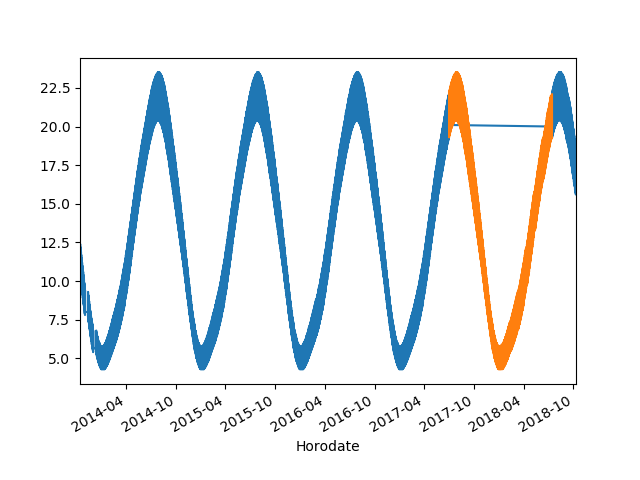

In [12]:
%matplotlib notebook
plt.figure()
train['2013-10-13':'2018-10-13']['Température normale lissée (°Celcius)'].plot()
test['Température normale lissée (°Celcius)'].plot()
plt.show()

In [13]:
train.drop('Horodate_UTC', axis=1, inplace=True)
test.drop('Horodate_UTC', axis=1, inplace=True)

/usr/lib64/python3.5/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Irrelevant features

In [14]:
train.columns

Index(['IDS', 'Mois', 'Injection RTE (W)', 'Refoulement RTE (W)',
       'Pertes modélisées (W)', 'Consommations totale (W)',
       'Consommation HTA télérelevée à courbe de charge (W)',
       'Consommation totale profilée (W)', 'Consommation HTA profilée (W)',
       'Consommation PME-PMI profilée (W)',
       'Consommation professionnelle profilée (W)',
       'Consommation résidentielle profilée (W)',
       'Production décentralisée totale (W)',
       'Production décentralisée télérelevée à courbe de charge (W)',
       'Production décentralisée profilée (W)',
       'Production photovoltaïque profilée (W)',
       'Production autre profilée (W)',
       'Température réalisée lissée (°Celcius)',
       'Température normale lissée (°Celcius)',
       'Production éolienne totale (W)',
       'Production photovoltaïque totale (W)', 'Pseudo rayonnement',
       'Consommation HTA totale (W)', 'Soutirage net vers autres GRD (W)',
       'RES1_BASE', 'RES11_BASE', 'PRO1_BASE', 'RES2_HC

In [15]:
train['test'] = 0
test['test'] = 1

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
data = pd.concat([train, test])

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


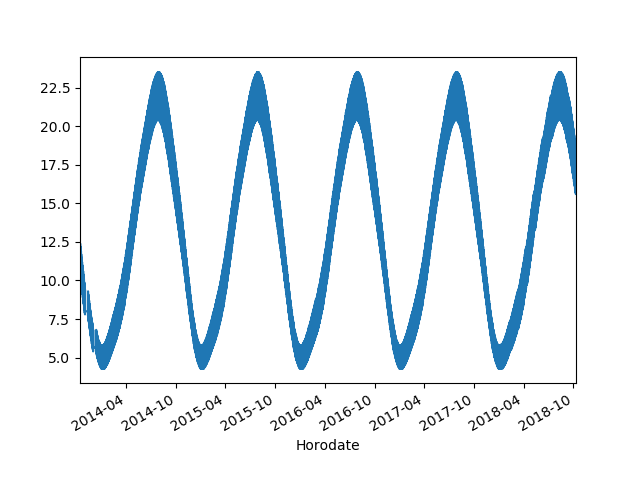

In [19]:
plt.figure()
data['Température normale lissée (°Celcius)'].plot()
plt.show()

In [23]:
pd.DataFrame.to_csv(train, TRAIN_MERGED)
pd.DataFrame.to_csv(test, TEST_MERGED)
DATA_MERGED = '/home_nfs/mcaitucoli-2047/Code/enedis/data/merged/data_merged.csv'
pd.DataFrame.to_csv(data, DATA_MERGED)